# Regression on Synthetic Data

In [1]:
random_state = 42

## Prerequisites

In [2]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_synth_regression_scoring,
    SHM_Scoring)
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from shm_experiments import conduct_ab_reg_experiment

time passed: 4.12 s
downloading synthetic data successful: True


In [4]:
result_file = "synthetic_regression_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

In [5]:
X, y = load_syn_reg_data(data_path=SYN_DATA_PATH,
                         min_radius = 1.9,
                         cache=True)

In [6]:
X.shape

(28302, 31)

In [7]:
cnt = Counter(y)
cnt

Counter({0.0: 990,
         2.2: 979,
         2.5: 979,
         2.8: 978,
         3.1: 986,
         3.4: 972,
         3.8: 973,
         4.1: 976,
         4.4: 979,
         4.7: 976,
         5.0: 977,
         6.7: 981,
         8.3: 972,
         10.0: 973,
         12.0: 969,
         14.0: 978,
         16.0: 980,
         18.0: 976,
         20.0: 974,
         22.0: 975,
         24.0: 980,
         26.0: 973,
         28.0: 983,
         30.0: 977,
         32.0: 967,
         34.0: 971,
         36.0: 976,
         38.0: 964,
         40.0: 968})

## A-B Experiments

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [9]:
estimator = SVR(kernel='rbf', C=50, gamma='scale', epsilon=.1)
pipeline = Pipeline([('est', estimator)])
svmrbf_pipeline = [("SVR", pipeline)]

In [10]:
estimator = KNeighborsRegressor(n_neighbors=1)
pipeline = Pipeline([('est', estimator)])

knn_pipeline_1 = [("KNN_1", pipeline)]

In [11]:
estimator = MLPRegressor(hidden_layer_sizes=(48,), learning_rate="adaptive")
pipeline = Pipeline([('est', estimator)])

mlp_pipeline_48 = [("MLP_48", pipeline)]

In [12]:
estimator = MLPRegressor(hidden_layer_sizes=(64,32,), learning_rate="adaptive")
pipeline = Pipeline([('est', estimator)])

mlp_pipeline_64_32 = [("MLP_64.32", pipeline)]

In [13]:
scoring = get_synth_regression_scoring()

In [14]:
results = conduct_ab_reg_experiment(X=X, y=y,
                                    estimators=[knn_pipeline_1,
                                                svmrbf_pipeline,
                                                mlp_pipeline_48,
                                                mlp_pipeline_64_32],
                                    n_splits=32,
                                    test_size=0.1,
                                    scoring=scoring,
                                    random_state=random_state)

## Store results for later

In [15]:
results.to_pickle(result_file)

## Plot some results for overview

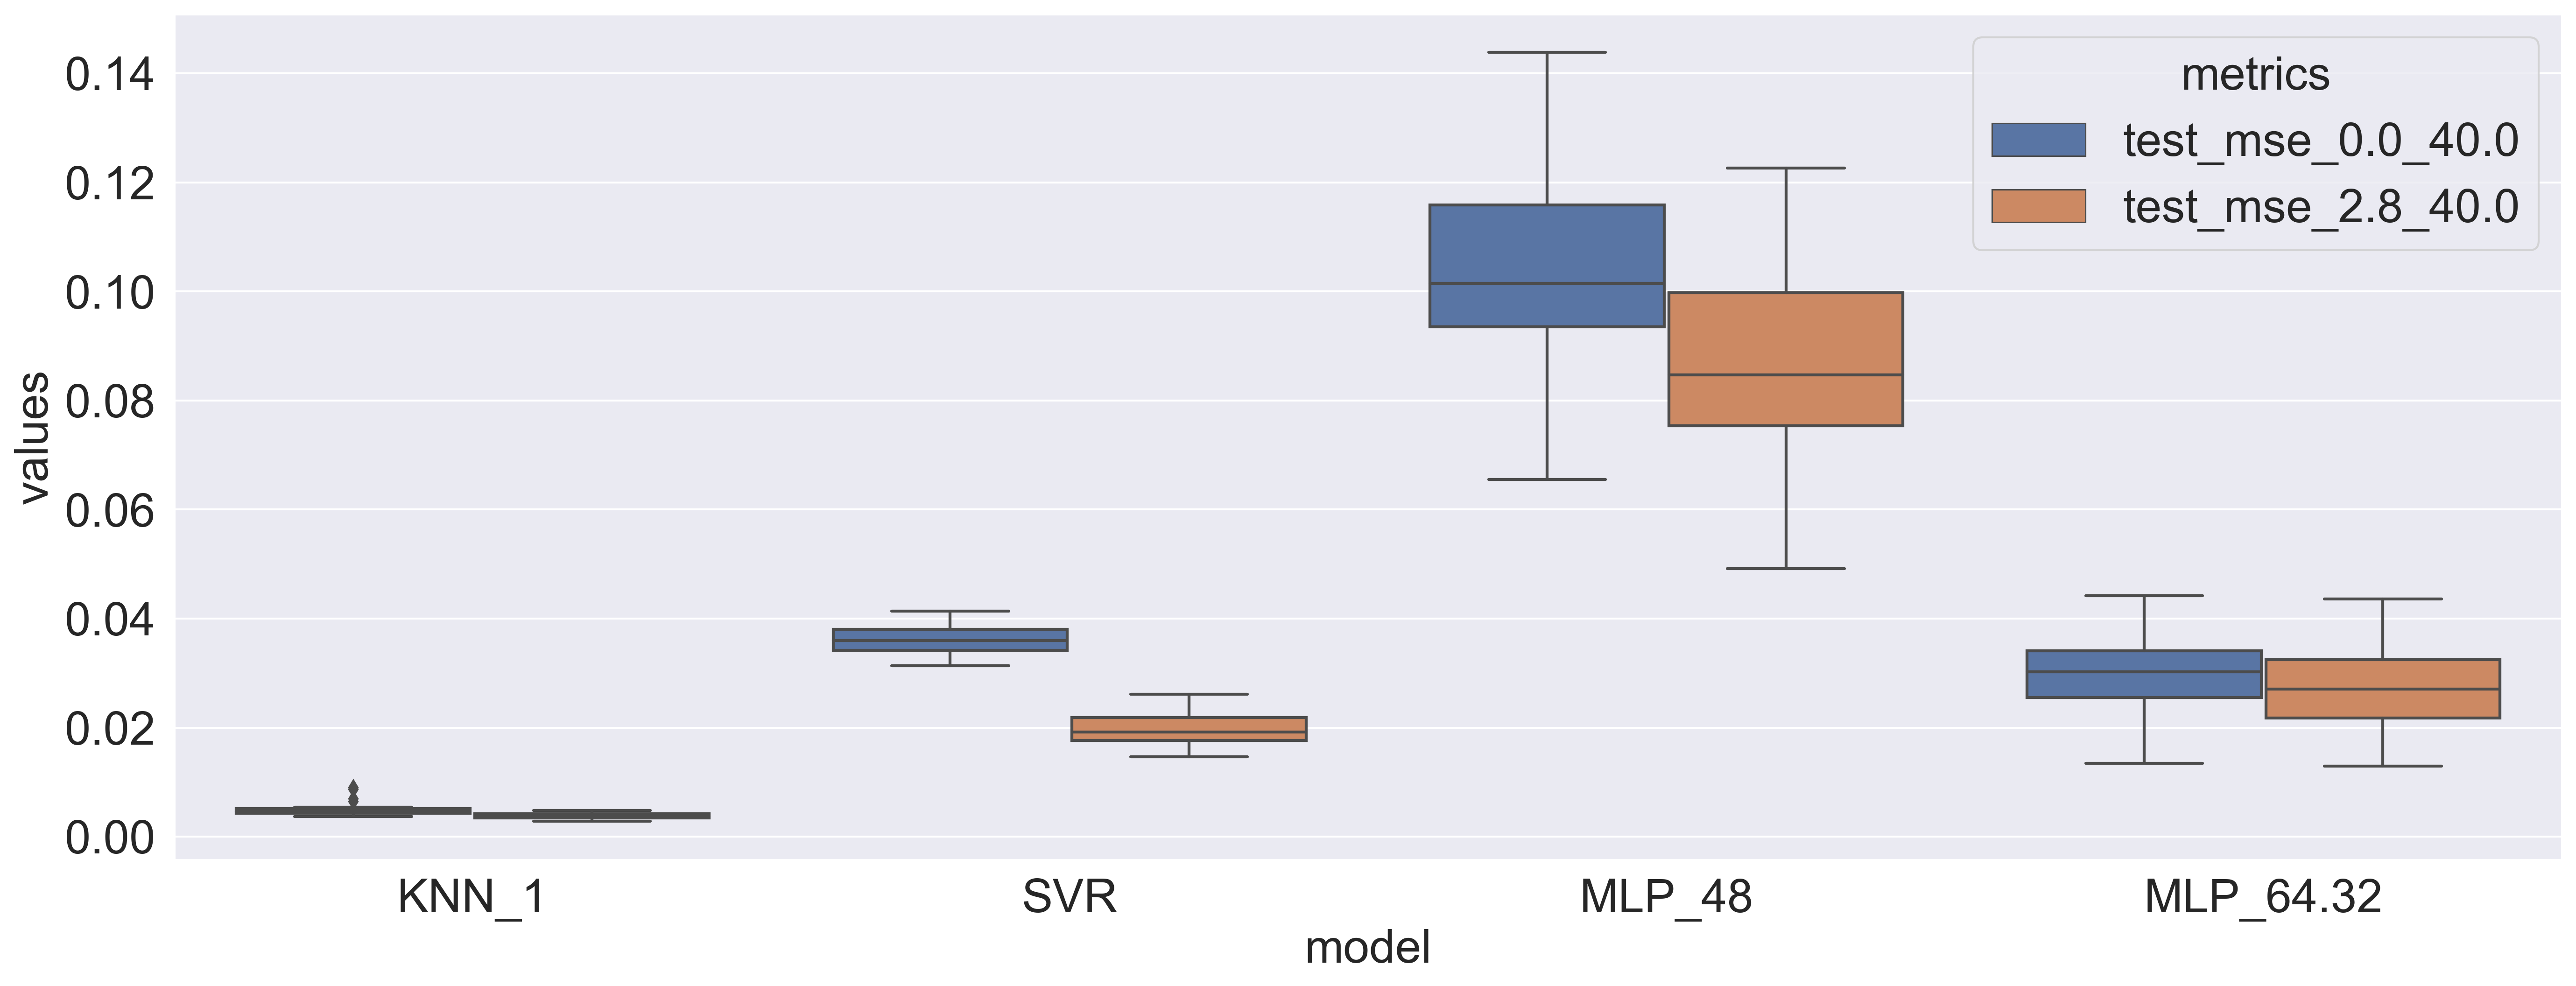

In [16]:
fig = plot_metrics(extract_metrics(results, ['test_mse_0.0_40.0',
                                             'test_mse_2.8_40.0']))
plt.show()

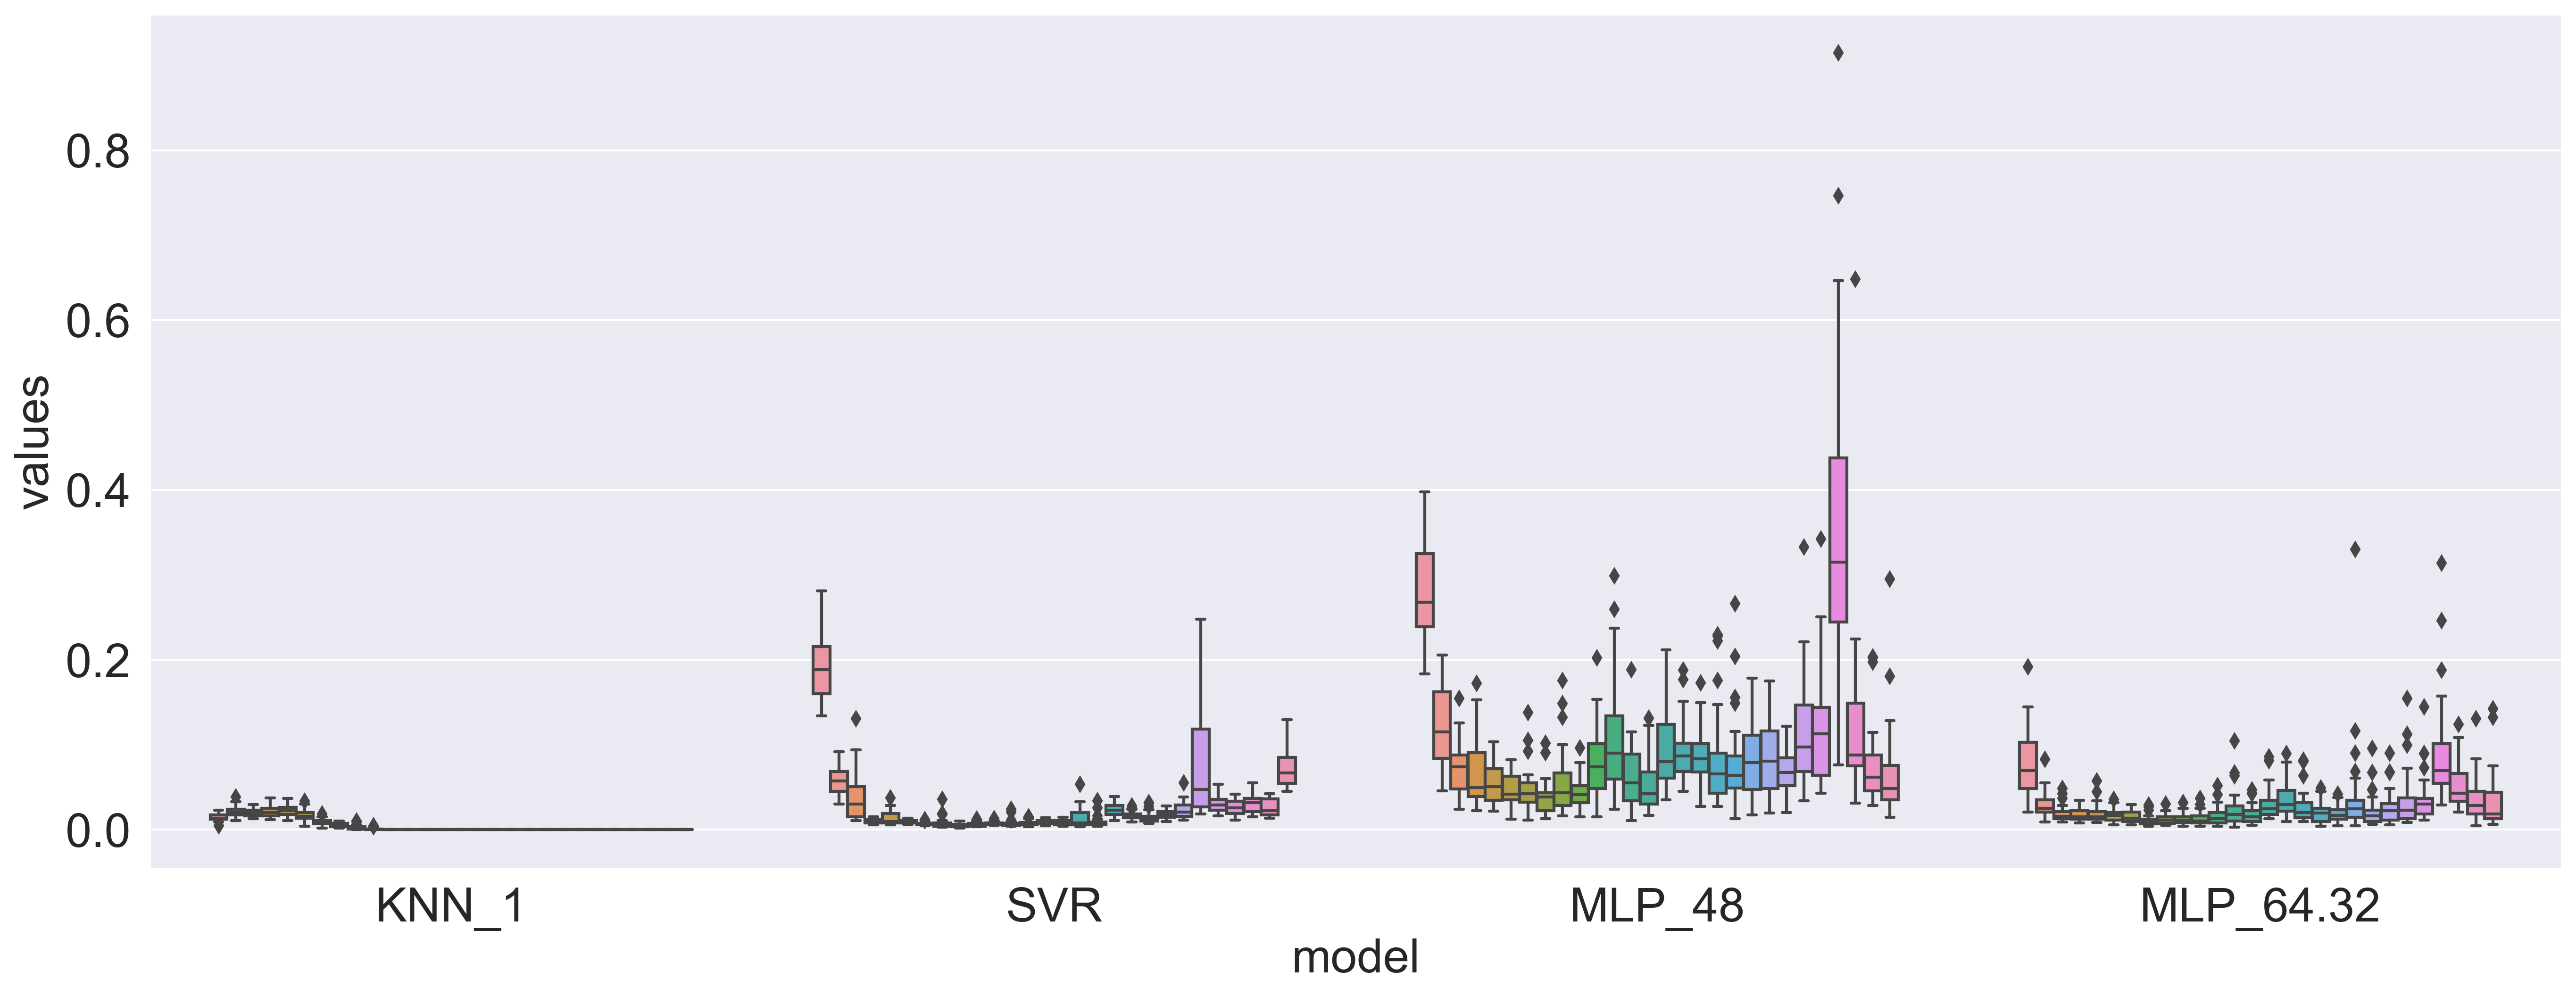

In [17]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.SYNTH_MSE_RESULTS))
plt.gca().get_legend().remove()

plt.show()

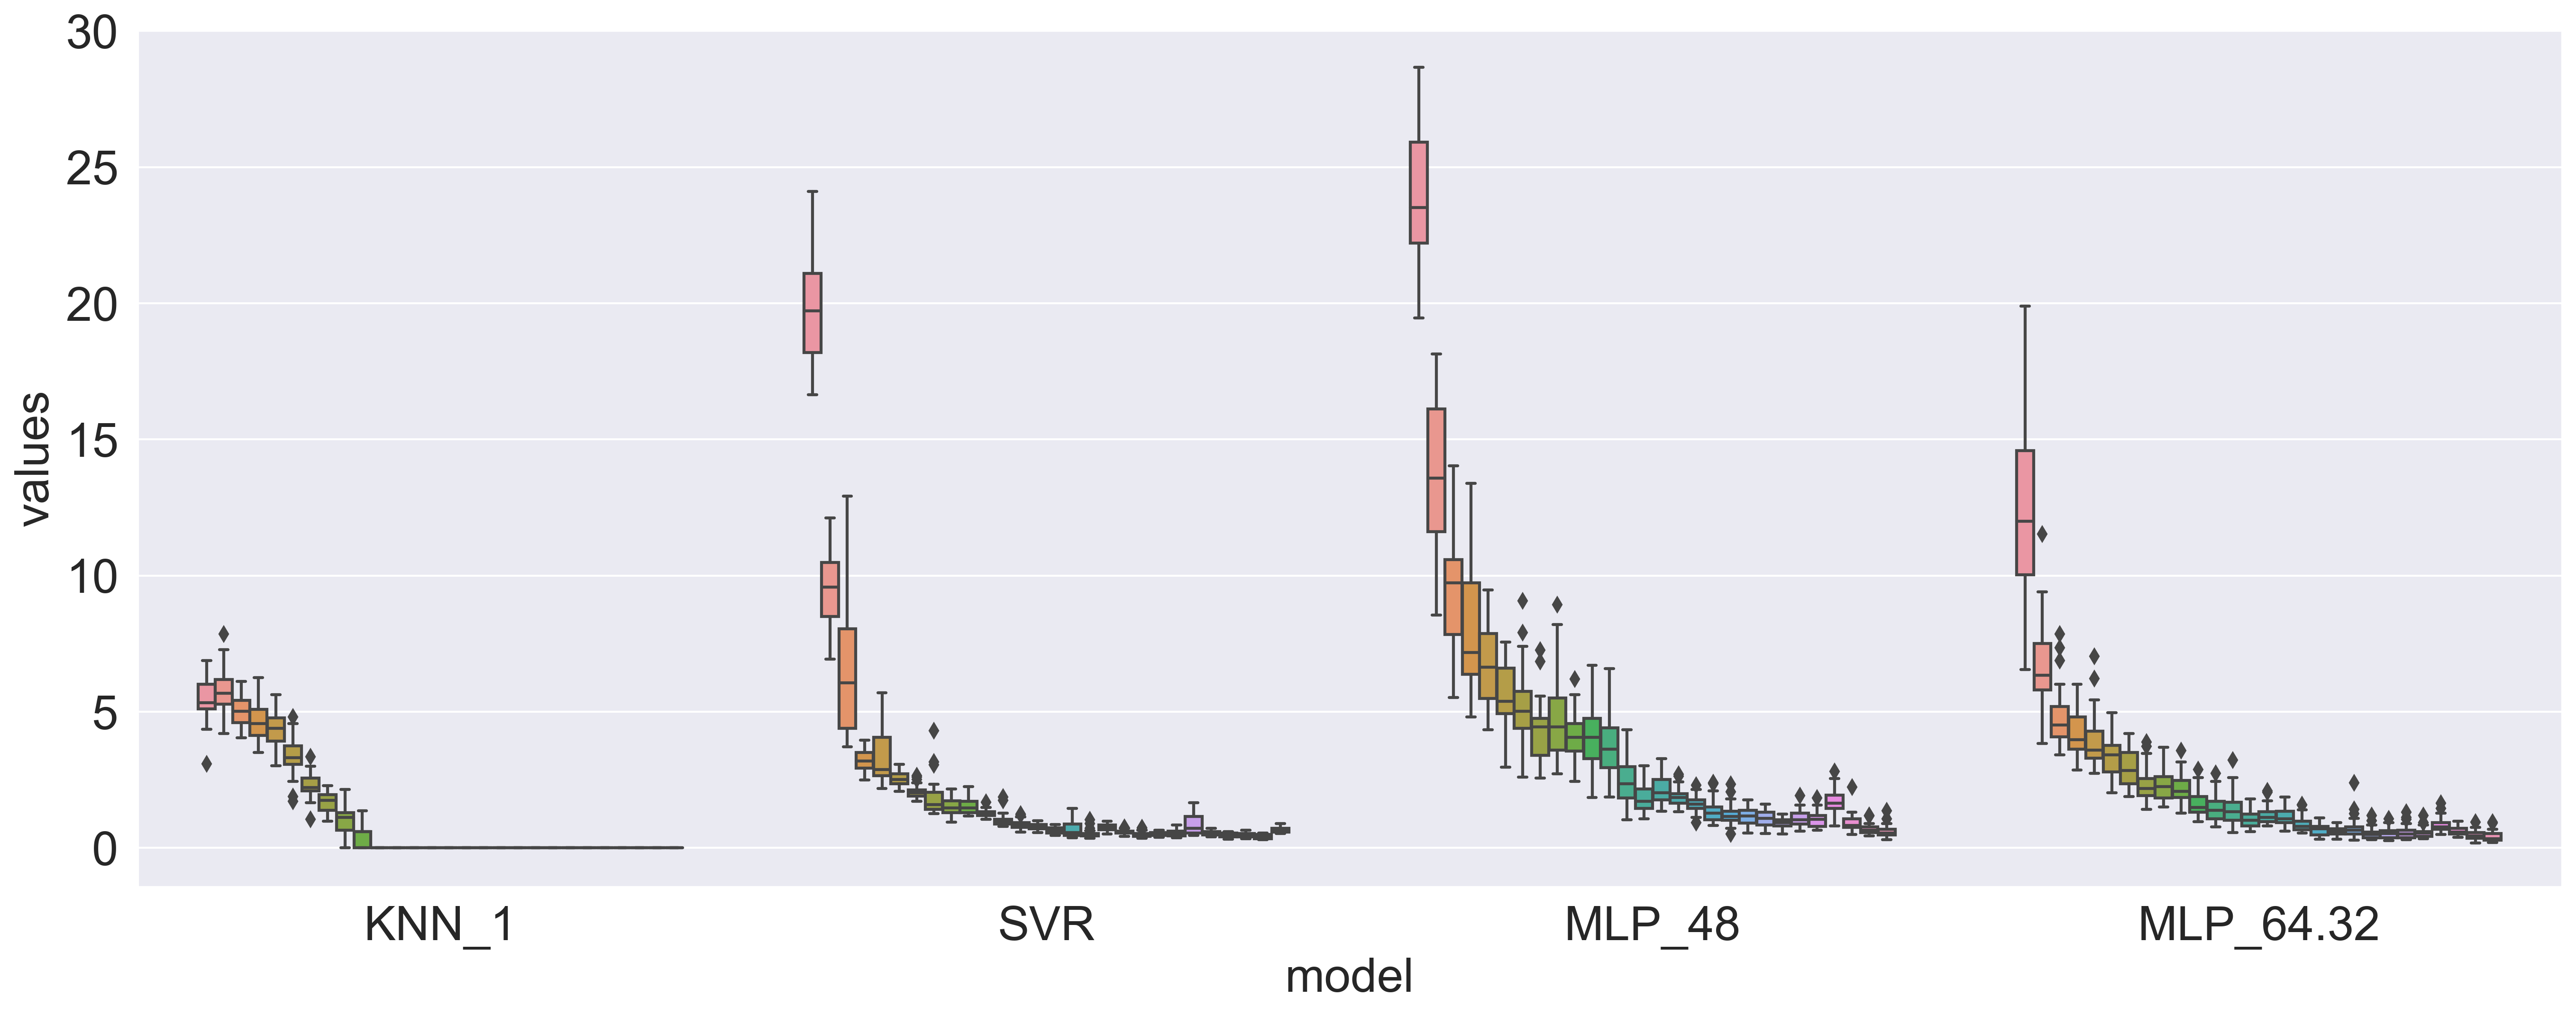

In [18]:
fig = plot_metrics(extract_metrics(results, shm_scoring.SYNTH_REL_ERROR))
plt.gca().get_legend().remove()

plt.show()